<div align="center">
    <h3>Optical Character Recognition using Deep Learning</h3>
</div>

<div align="center">
    <h4>by Achilles Rasquinha</h4>
</div>

The *Handwritten Digit Recognition Problem* is like the [`"Hello, World!"`](https://en.wikipedia.org/wiki/%22Hello,_World!%22_program) sample to Deep Learning (or like [Lenna](https://en.wikipedia.org/wiki/Lenna) to Computer Vision).

#### Prerequisites

In [1]:
# Add your dependencies to the `REQUIRED_PACKAGES` list
REQUIRED_PACKAGES = \
[
    'six',             # Python 2 + Python 3 = six (support for both - 2 and 3)
    'addict',          # addict is to Python what an Object is to JavaScript
    'requests',        # HTTP library for humans
    'tqdm',            # Progress Indicator library
    'numpy',           # Linear Algebra library
    'scipy',           # MATLAB equivalent
    'matplotlib',      # Data Visualization library
    'pandas',          # Data Analysis library
    'scikit-learn',    # Machine Learning library
    'tensorflow',      # Google's Machine and Deep Learning library
    'h5py',            # Python handler for HDF5 file format
    'tflearn', 'keras' # High-Level APIs for TensorFlow
]

# Have pip install your dependencies
import pip
pip.main(['install'] + REQUIRED_PACKAGES)

0

In [2]:
# imports - compatibility imports
import six

# imports - standard imports
from   abc          import ABCMeta, abstractmethod
import os, errno
from   urllib.parse import urljoin
import struct
import gzip, tarfile
import logging
import html, uuid
if six.PY2:
    import cPickle as pickle
else:
    import pickle

# imports - third-party imports
import addict
import requests
import numpy  as np
import matplotlib.pyplot as pplt
import matplotlib.cm     as cmap
import pandas as pd
from   sklearn.metrics import classification_report
from   tqdm            import tqdm
from   IPython.display import display, HTML

pplt.style.use('seaborn')

pplt.rcParams['figure.figsize'] = tuple(np.array(pplt.rcParams['figure.figsize']) * 3)

In [3]:
# Setting up a logger for debugging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [4]:
# an IPython magic function to ask for inline plots
% matplotlib inline

In [5]:
# Custom Constants
ABSPATH_DATA  = os.path.abspath('data')
ABSPATH_TEMP  = os.path.join(ABSPATH_DATA, 'tmp')

# A routine which creates directories, optionally handles if they exist
def makedirs(dirs, exists_ok = False):
    try:
        os.makedirs(dirs)
    except OSError as e:
        if e.errno != errno.EEXIST or not exists_ok:
            raise
            
# A download helper
def download(url, path, exists_ok = True):
    if not exists_ok or not os.path.exists(path):
        # Download the requested resource
        res = requests.get(url, stream = True)

        if res.ok:
            logger.info('Downloading {url} to {path}'.format(url = url, path = path))
            # Save resource to disk at desired path
            with open(path, mode = 'wb') as f:
                for chunk in tqdm(res.iter_content(chunk_size = 1024)):
                    f.write(chunk)
            logger.info('Download successful')
        else:
            logger.error('Error downloading {url}.'.format(url = url))
            res.raise_for_status()
    else:
        logger.info('{path} available.'.format(path = path))
            
# A routine which returns a UUID string without hyphens
def get_uuid_str():
    objekt   = uuid.uuid4()
    string   = str(objekt)
    sanitize = string.replace('-', '')
    
    return sanitize

def assign_if_none(a, b):
    if a == None:
        a = b
        
    return a

#### Data Gathering

In [6]:
# Yann LeCun's website - the Official Link to the MNIST dataset
URL_BASE  = 'http://yann.lecun.com/exdb/mnist/'
# List of available files on the website
FILENAMES = \
[
    'train-images-idx3-ubyte.gz', 't10k-images-idx3-ubyte.gz', # 60,000 + 10,000 images
    'train-labels-idx1-ubyte.gz', 't10k-labels-idx1-ubyte.gz'
]

In [7]:
# Save your raw files in a directory data/mnist
ABSPATH_MNIST = os.path.join(ABSPATH_DATA, 'mnist')

In [8]:
makedirs(ABSPATH_MNIST, exists_ok = True)

In [9]:
ls data/

checkpoint  cifar10/    mnist/      tmp/


In [10]:
for i, filename in enumerate(FILENAMES):
    url  = urljoin(URL_BASE, filename)
    path = os.path.join(ABSPATH_MNIST, filename)
    
    download(url, path, exists_ok = True)

/Users/achilles/Desktop/dev/DeepLearning/notebooks/data/mnist/train-images-idx3-ubyte.gz available.
/Users/achilles/Desktop/dev/DeepLearning/notebooks/data/mnist/t10k-images-idx3-ubyte.gz available.
/Users/achilles/Desktop/dev/DeepLearning/notebooks/data/mnist/train-labels-idx1-ubyte.gz available.
/Users/achilles/Desktop/dev/DeepLearning/notebooks/data/mnist/t10k-labels-idx1-ubyte.gz available.


In [11]:
ls -al data/mnist

total 27992
drwxr-xr-x  10 achilles  staff      340 Sep 10 20:40 ./
drwxr-xr-x   8 achilles  staff      272 Sep 13 17:26 ../
-rw-r--r--   1 achilles  staff      231 Sep 10 20:40 checkpoint
-rw-r--r--   1 achilles  staff  1648877 Aug 19 12:28 t10k-images-idx3-ubyte.gz
-rw-r--r--   1 achilles  staff     4542 Aug 19 12:28 t10k-labels-idx1-ubyte.gz
-rw-r--r--   1 achilles  staff  2678824 Sep 10 20:40 t10k-labels-idx1-ubyte.gz.data-00000-of-00001
-rw-r--r--   1 achilles  staff      275 Sep 10 20:40 t10k-labels-idx1-ubyte.gz.index
-rw-r--r--   1 achilles  staff    32537 Sep 10 20:40 t10k-labels-idx1-ubyte.gz.meta
-rw-r--r--   1 achilles  staff  9912422 Aug 19 12:28 train-images-idx3-ubyte.gz
-rw-r--r--   1 achilles  staff    28881 Aug 19 12:28 train-labels-idx1-ubyte.gz


#### Data Preprocessing

<div align="center">
    <img src="res/img/MNIST-matrix.png"/>
</div>

In [12]:
def load_mnist():
    train, test = dict(), dict()
    
    for i, filename in enumerate(FILENAMES):
        path = os.path.join(ABSPATH_MNIST, filename)
        
        # Using python's gzip library to unpack files
        with gzip.open(path, mode = 'rb') as f:
            if 'labels' in filename:
                data = f.read(8)  # fetch the first 8 bytes and move file pointer pointing to the 9th byte
                magic, size = struct.unpack('>II', data)
                
                # Check if the file signature is correct
                if magic != 2049:
                    raise ValueError('Expected magic number 2049, got {magic} instead.'.format(magic = magic))
                    
                buffrr = f.read()
                # Convert bytes to array of desired type
                labels = np.frombuffer(buffrr, dtype = np.uint8)
                
                if 'train' in filename:
                    train['labels'] = labels
                else:
                     test['labels'] = labels
                
            if 'images' in filename:
                data = f.read(16) # fetch the first 16 bytes and move file pointer pointing to the 17th byte
                magic, size, rows, cols = struct.unpack('>IIII', data)
                
                # Check if the file signature is correct
                if magic != 2051:
                    raise ValueError('Expected magic number 2051, got {magic} instead.'.format(magic = magic))
                    
                buffrr = f.read()
                images = np.reshape(np.frombuffer(buffrr, dtype = np.uint8), (size, rows * cols))
                
                if 'train' in filename:
                    train['images'] = images
                else:
                     test['images'] = images
                        
    # wrap processed data into a Pandas DataFrame                 
    train = pd.DataFrame(np.concatenate((train['images'], np.atleast_2d(train['labels']).T), axis = 1))
    test  = pd.DataFrame(np.concatenate(( test['images'], np.atleast_2d( test['labels']).T), axis = 1))
    
    return train, test

In [13]:
train, test  = load_mnist()
train.head(4)

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


#### Data Visualization

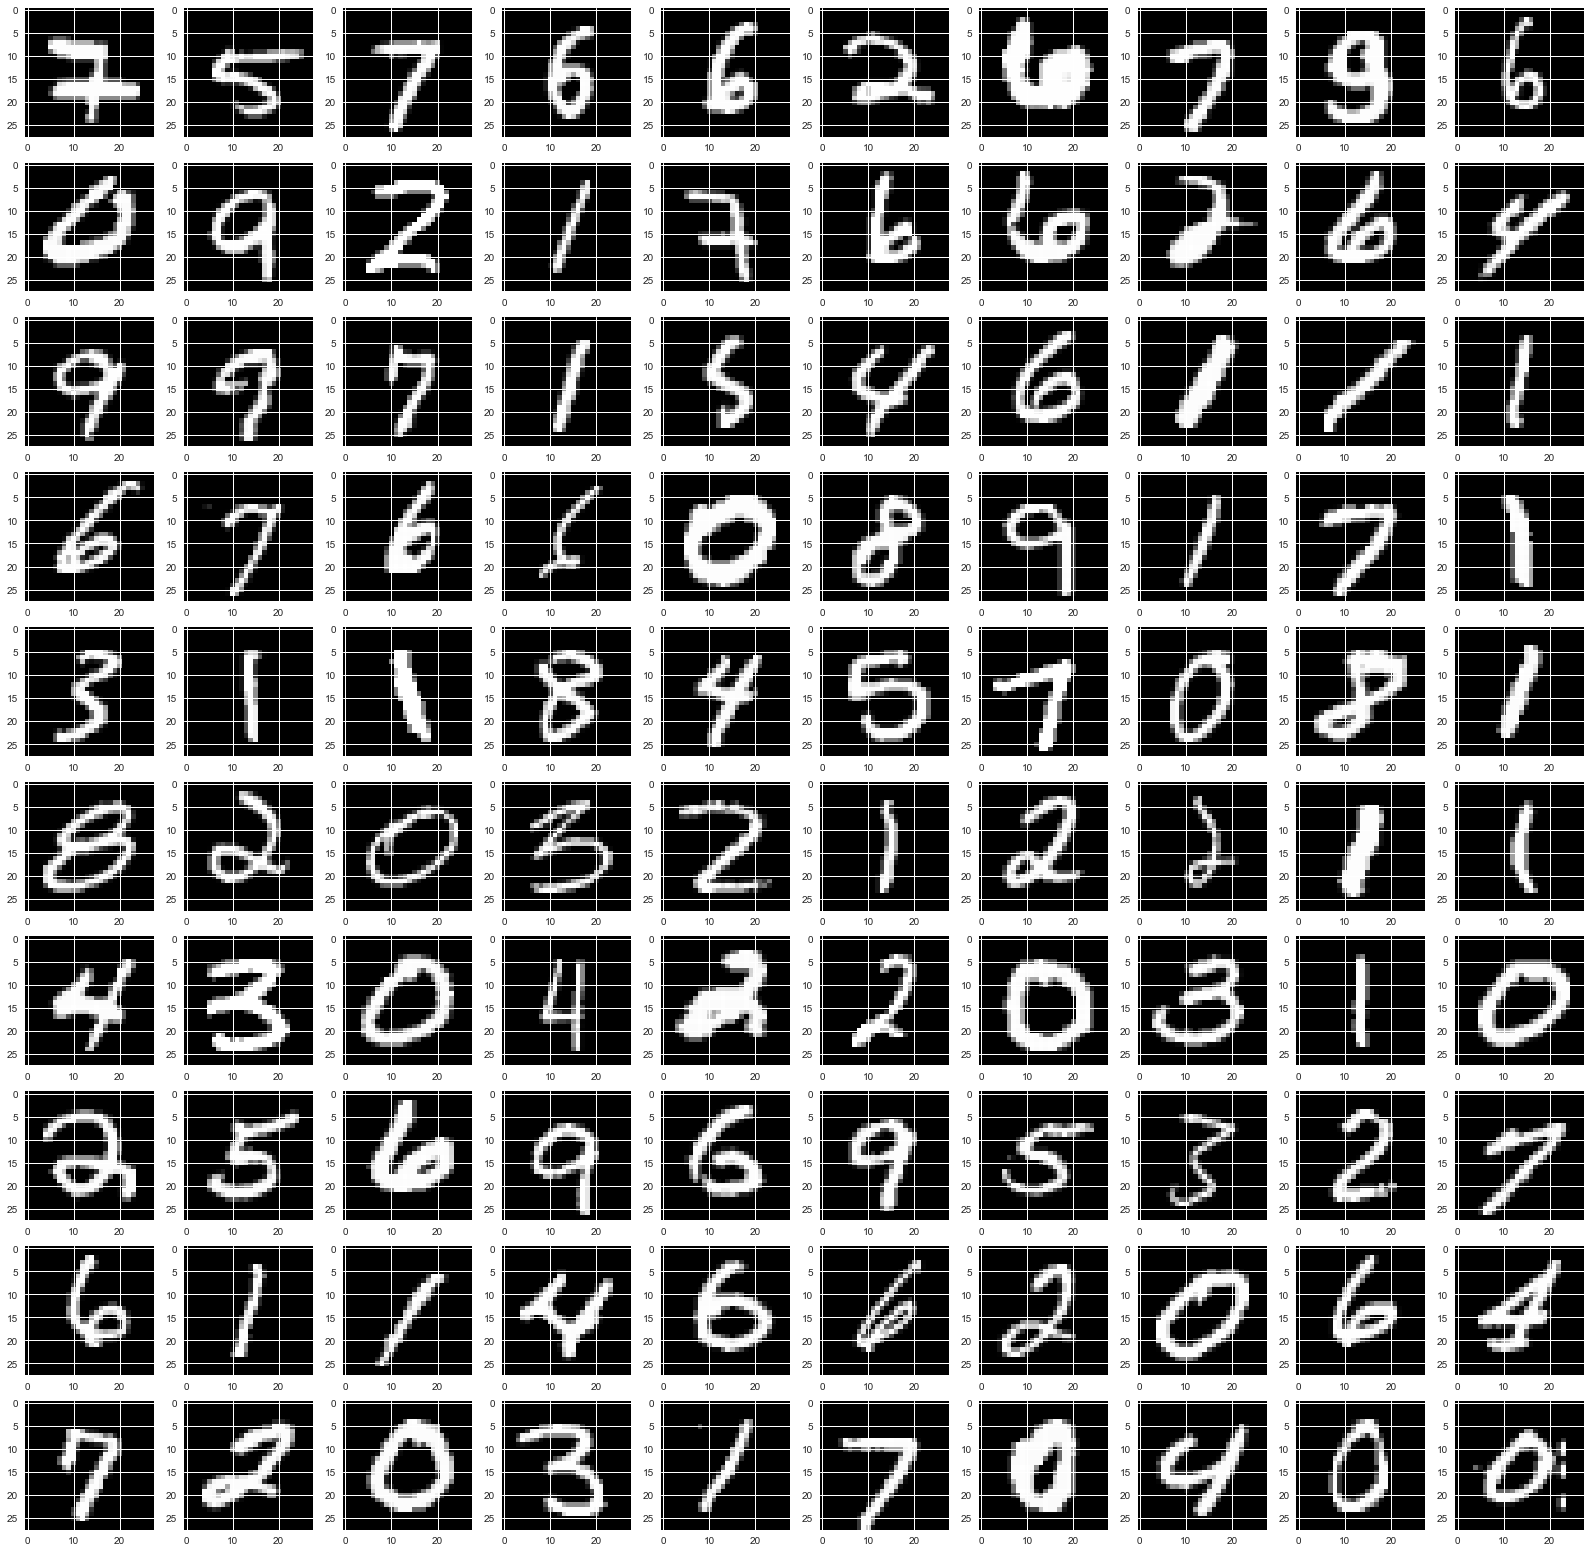

In [14]:
rows, cols   = 10, 10

figure, axes = pplt.subplots(rows, cols, figsize = (28, 28))
sample       = train.sample(rows * cols)

axes         = np.ravel(axes)
values       = sample.values

for i, ax in enumerate(axes):
    image = values[i,:-1].reshape((28, 28))
    
    ax.imshow(image, cmap = cmap.gray)

#### Data Preprocessing

In [15]:
Xtrain, Xtest, ytrain, ytest = train.iloc[:,:-1], test.iloc[:,:-1], train.iloc[:,-1], test.iloc[:,-1]

In [16]:
len(train) / (len(train) + len(test))

0.8571428571428571

##### Normalization

$$X = a + \frac{(X - X_{min})(b - a)}{X_{max} - X_{min}}$$

Why Normalization?
- Faster Learning
- Bringing Data Points on Same Scales

In [17]:
def mmin(frame):
    value = np.min(np.ravel(frame))
    
    return value

def mmax(frame):
    value = np.max(np.ravel(frame))
    
    return value

# Feature Scaling between 0, 1
def normalize(frame, scale = (0, 1)):
    a, b   = scale
    mi, ma = mmin(frame), mmax(frame)
    frame = a + ((frame - mi) * (b - a)) / (ma - mi)
    
    return frame

In [18]:
Xtrain, Xtest = normalize(Xtrain), normalize(Xtest)

In [19]:
Xtrain.head(5)

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### One-Hot Encoding

Why One-Hot Encoding?
1. Machines don't understand classes, just numbers. 
2. Removing the "Ordinal" Characteristic of Variables

In [20]:
ytrain, ytest = pd.get_dummies(ytrain), pd.get_dummies(ytest)

In [21]:
ytrain.head(5)

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1


![](https://www.tensorflow.org/_static/images/tensorflow/logo.png)

In [22]:
from tensorflow.examples.tutorials.mnist import input_data

In [23]:
mnist = input_data.read_data_sets(ABSPATH_MNIST, one_hot = True)

Extracting /Users/achilles/Desktop/dev/DeepLearning/notebooks/data/mnist/train-images-idx3-ubyte.gz
Extracting /Users/achilles/Desktop/dev/DeepLearning/notebooks/data/mnist/train-labels-idx1-ubyte.gz
Extracting /Users/achilles/Desktop/dev/DeepLearning/notebooks/data/mnist/t10k-images-idx3-ubyte.gz
Extracting /Users/achilles/Desktop/dev/DeepLearning/notebooks/data/mnist/t10k-labels-idx1-ubyte.gz


In [24]:
mnist.train.images

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

![](https://www.tensorflow.org/images/tensors_flowing.gif)

The canonical way of importing TFlow is as follows:

In [25]:
import tensorflow as tf

### `tf.placeholder`

Placeholders can be considered as **data feeders**, awaiting for data to be fed into the model.

```python
>>> import tensorflow as tf
>>> tf.placeholder(tf.float32, shape = (1024, 1024))
```

**Syntax**: `tf.placeholder(datatype, shape = None, name = None)`

In [26]:
tf.placeholder(tf.float32, [None, 128])

<tf.Tensor 'Placeholder:0' shape=(?, 128) dtype=float32>

### `tf.Variable`

Modifyable during runtime of TensorFlow's Graph
```python
>>> import tensorflow as tf
>>> tf.Variable(tf.zeros([128, 128]))
```

**Syntax**: `tf.Variable(initial_value)`

In [27]:
tf.Variable(tf.zeros([128, 128]))

<tf.Variable 'Variable:0' shape=(128, 128) dtype=float32_ref>

### `tf.Graph`

* TFlow's Data Flow Graph, declaring tensors and operations within its scope
* By default, TFlow creates a default graph
* Declarations are not thread-safe

In [28]:
graph = tf.Graph()

In [29]:
with graph.as_default():
    a, b = tf.constant(1), tf.constant(10)
    add  = tf.add(a, b)

### `tf.Session`

A Session object encapsulates the environment in which Operation objects are executed, and Tensor objects are evaluated.
```python
>>> import tensorflow as tf
>>> a, b = tf.constant(1), tf.constant(10)
>>> add  = tf.add(a, b)
>>> with tf.Session() as sess:
...     sess.run(add)
```

In [30]:
with tf.Session() as sess:
    print(sess.run(tf.constant(1)))

1


In [31]:
with tf.Session(graph = graph) as sess:
    print(sess.run(add))

11


#### Modelling

![](http://www.asimovinstitute.org/wp-content/uploads/2016/09/neuralnetworks.png)

In [32]:
class NN(metaclass = ABCMeta):
    def __init__(self, name = None):
        self.graph = tf.Graph()
        self.name  = assign_if_none(name, 'model-{uuid}'.format(uuid = get_uuid_str()))
        
    @abstractmethod
    def fit(self, X, y):
        pass
    
    @abstractmethod
    def predict(self, X):
        pass

In [33]:
INITIALIZERS = dict(
    randn    = tf.random_normal,
    xavier   = tf.contrib.layers.xavier_initializer
)

In [34]:
ACTIVATIONS  = dict(
    sigmoid  = tf.nn.sigmoid,
    relu     = tf.nn.relu,
    softmax  = tf.nn.softmax,
    categorical_crossentropy = tf.nn.softmax_cross_entropy_with_logits,
    tanh     = tf.tanh
)

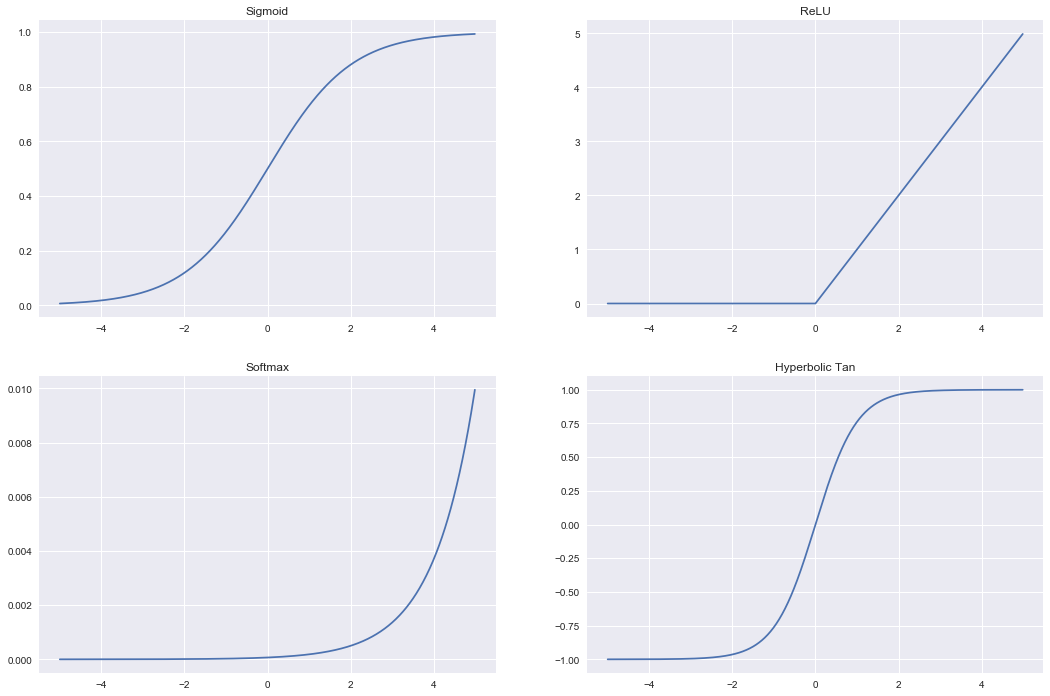

In [35]:
rows, cols   = 2, 2

figure, axes = pplt.subplots(rows, cols, figsize = (18, 12))
sample       = np.arange(-5, 5, 0.01)

axes         = np.ravel(axes)
activations  = [
    addict.Dict({
        'function': lambda x: 1 / (1 + np.exp(-x)),
            'name': 'Sigmoid'
    }),
    addict.Dict({
        'function': lambda x: np.maximum(0, x),
            'name': 'ReLU'
    }),
    addict.Dict({
        'function': lambda x: np.exp(x) / np.sum(np.exp(x)),
            'name': 'Softmax'
    }),
    addict.Dict({
        'function': lambda x: np.tanh(x),
            'name': 'Hyperbolic Tan'
    })
]

for i, ax in enumerate(axes):
    ax.plot(sample, activations[i].function(sample))
    ax.set_title(activations[i].name)

### Optimizers

![](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/03/06100746/grad.png)
<div align="center">
   <h4>Gradient Descent Optimizer</h4>
</div>

In [36]:
OPTIMIZERS  = dict(
    sgd     = tf.train.GradientDescentOptimizer,
    adam    = tf.train.AdamOptimizer,
    adagrad = tf.train.AdagradOptimizer,
    rmsprop = tf.train.RMSPropOptimizer
)

#### Neural Network - Hypothesis
$$y = \phi(Wx + B)$$

```python
>>> import tensorflow as tf
>>> y = tf.nn.softmax(tf.matmul(x, W) + B)
```

In [37]:
class MLP(NN):                        # Multi Layer Perceptron
    def fit(self, X, y,               # Supervised Learning Algorithm
                                      # OPTIONAL ARGUMENTS
            hidden        = (100,),   # number of neurons in each hidden layer
            init          = 'xavier', # initializer to be used (for weights and biases)
            activation    = 'categorical_crossentropy', # activation function to be used
            optimizer     = 'adam',   # optimizer to be used
            learning_rate = 0.001,    # learning rate for the optimizer
            epochs        = 10,       # number of epochs
            batch_size    = 100):     # batch size to be fed
        if init not in INITIALIZERS:
            raise ValueError('No initializer {init} found.'.format(init = init))
            
        if activation not in ACTIVATIONS:
            raise ValueError('No activation function {activation} found.'.format(activation = activation))
        
        if optimizer not in OPTIMIZERS:
            raise ValueError('No optimizer {optimizer} found.')
            
        with self.graph.as_default():
            ninputs  = len(X.columns) # number of inputs
            noutputs = len(y.columns) # number of outputs

            self.input  = tf.placeholder(tf.float32, (None, ninputs) , name = 'x') # input-x placeholder
            self.yph    = tf.placeholder(tf.float32, (None, noutputs), name = 'y') # input-y placeholder

            # number of neurons in each layer
            nneurons    = (ninputs,) + hidden + (noutputs,)
            self.output = self.input

            # building the graph
            for i in range(len(nneurons) - 1):
                prev, nest = nneurons[i], nneurons[i + 1]

                shape    = (prev, nest)
                initial  = INITIALIZERS[init](shape) # initialize with an initializer
                W        = tf.Variable(initial)      # weight matrix of size i x j from ith to jth layer

                shape    = (nest,)
                initial  = INITIALIZERS[init](shape) # initialize with an initializer
                B        = tf.Variable(initial)      # bias matrix of size j for the jth layer

                self.output = tf.add(tf.matmul(self.output, W), B, name = 'output') # output layer
                
            # activation function for non-linear mapping
            softmax    = ACTIVATIONS[activation](labels = self.yph, logits = self.output)
            # cost function
            self.cost  = tf.reduce_mean(softmax)
            optimizer  = OPTIMIZERS[optimizer](learning_rate = learning_rate)
            train      = optimizer.minimize(self.cost)
            
            # accuracy
            prediction    = tf.equal(tf.argmax(self.yph, 1), tf.argmax(self.output, 1))
            self.accuracy = tf.reduce_mean(tf.cast(prediction, tf.float32))

            init          = tf.global_variables_initializer()
            
        self.history          = addict.Dict()
        self.history.loss     = [ ]
        self.history.accuracy = [ ]

        # training phase
        with tf.Session(graph = self.graph) as sess:
            sess.run(init)

            for i in tqdm(range(epochs)):
                nchunks = int(len(X) / batch_size)
                loss  = [ ]
                accs  = [ ]
                
                for j in range(nchunks):
                    # send batch-wise
                    next_   = j * batch_size
                    Xbatch  = X.iloc[next_:next_ + batch_size]
                    ybatch  = y.iloc[next_:next_ + batch_size]

                    _, a, l = sess.run((train, self.accuracy, self.cost), feed_dict = {
                        self.input: Xbatch,
                          self.yph: ybatch
                    })
                    
                    loss.append(l)
                    accs.append(a)
                    
                self.history.loss.append(loss)
                self.history.accuracy.append(accs)
                
            basepath = os.path.join(ABSPATH_TEMP, self.name)
            saver    = tf.train.Saver()
        
            makedirs(basepath, exists_ok = True)

            saver.save(sess, os.path.join(basepath, self.name))
            
    def evaluate(self, X, y):
        with tf.Session(graph = self.graph) as sess:
            # restore a saved model
            basepath    = os.path.join(ABSPATH_TEMP, self.name)
            metapath    = os.path.join(basepath, '{name}.meta'.format(name = self.name))
            saver       = tf.train.import_meta_graph(metapath)
            check       = tf.train.latest_checkpoint(basepath)

            saver.restore(sess, check)
            
            loss, acc = sess.run((self.cost, self.accuracy), feed_dict = {
                self.input: X,
                  self.yph: y
            })
            
        return loss, acc
                
    def predict(self, X):
        with tf.Session(graph = self.graph) as sess:
            # restore a saved model
            basepath    = os.path.join(ABSPATH_TEMP, self.name)
            metapath    = os.path.join(basepath, '{name}.meta'.format(name = self.name))
            saver       = tf.train.import_meta_graph(metapath)
            check       = tf.train.latest_checkpoint(basepath)

            saver.restore(sess, check)
            
            pred = sess.run(self.output, feed_dict = {
                self.input: X
            })
            
        return pred
    
    def summary(self):
        figure, axes = pplt.subplots(2, 1, figsize = (18, 12))
        axes         = np.ravel(axes)
        
        for i in range(len(self.history.loss)):
            nbatch = len(self.history.loss[i])
            prev   = i * nbatch
            nest   = prev + nbatch
            sbatch = np.arange(prev, nest)
            
            axes[0].plot(sbatch, self.history.loss[i])
            
            axes[0].set_xlabel('Batch')
            axes[0].set_ylabel('Loss (Training)')
            
            axes[1].plot(sbatch, self.history.accuracy[i])
            
            axes[1].set_xlabel('Batch')
            axes[1].set_ylabel('Accuracy (Training)')

In [38]:
model     = MLP()
model.fit(Xtrain, ytrain,
          init      = 'randn',
          hidden    = (512, 512),
          epochs    = 1,
          optimizer = 'sgd')

100%|██████████| 1/1 [00:07<00:00,  7.19s/it]


In [39]:
tf.logging.set_verbosity(logging.ERROR)

In [40]:
loss, acc = model.evaluate(Xtest, ytest)

print('Accuracy: {accuracy}'.format(accuracy = acc))

Accuracy: 0.8708999752998352


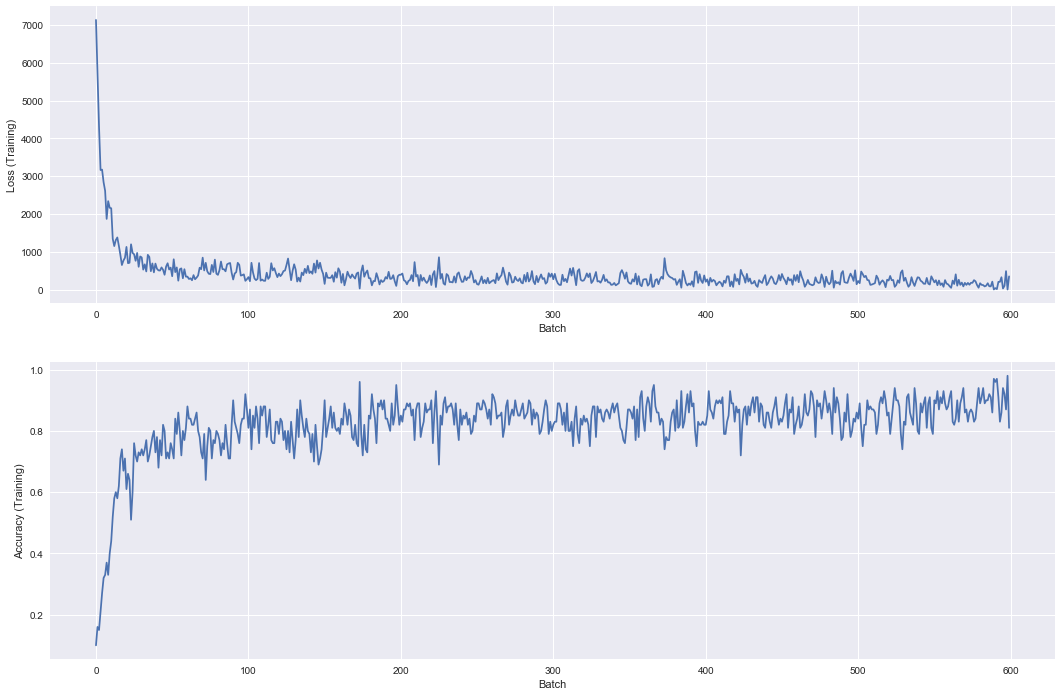

In [41]:
model.summary()

In [42]:
pred   = np.argmax(model.predict(Xtest), 1)
actual = ytest.idxmax(axis = 1)

In [43]:
report = classification_report(pred, actual, target_names = list(map(str, range(0, 10))))

print(report)

             precision    recall  f1-score   support

          0       0.97      0.93      0.95      1028
          1       0.98      0.89      0.93      1254
          2       0.78      0.91      0.84       877
          3       0.88      0.82      0.85      1088
          4       0.89      0.87      0.88      1003
          5       0.81      0.81      0.81       888
          6       0.93      0.91      0.92       977
          7       0.82      0.94      0.87       895
          8       0.74      0.86      0.79       833
          9       0.90      0.79      0.84      1157

avg / total       0.88      0.87      0.87     10000



### TFlow Board

In [44]:
class Board:
    def show(model, height = 600):
        graph  = model.graph.as_graph_def()
        name   = model.name
        
        source = \
        '''
            <script>
                function on_load () {{
                    var element   = document.getElementById("{id_}");
                    element.pbtxt = {data};
                }}
            </script>
            <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=on_load()>
            <div style="height: {height}px;">
                <tf-graph-basic id="{id_}"/>
            </div>
        '''.format(id_ = name, data = repr(str(graph)), height = height)
        source = html.escape(source)
        
        iframe = '<iframe style="width: 100%; height: {height}px; border:0" srcdoc="{src}"/>'.format(src = source, height = height)
        
        display(HTML(iframe))

In [45]:
Board.show(model)

### High-Level APIs

### `keras`
##### Multi Layer Perceptron
```python
>>> from keras.models import Sequential
>>> from keras.layers import Dense, Dropout
>>> model = Sequential()                                          
>>> model.add(Dense(512, activation = 'relu', input_shape(784,))) # hidden layer (512 neurons, ReLU activation)
>>> model.add(Dropout(0.2))                                       # 20% dropout
>>> model.add(Dense(512, activation = 'relu'))                    # hidden layer (512 neurons, ReLU activation)
>>> model.add(Dropout(0.2))                                       # 20% dropout
>>> model.add(Dense(10,  activation = 'softmax'))                 # output layer (10 neurons, softmax activation)
>>> model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['loss', 'accuracy'])
>>> # NumPy arrays (Returns Training History)
>>> history   = model.fit(Xtrain, ytrain, batch_size = 100, epochs = 10)
>>> # NumPy arrays (Returns Loss, Accuracy)
>>> loss, acc = model.evaluate(Xtest, ytest)                            
```

In [46]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(512, activation = 'relu', input_shape = (len(Xtrain.columns),))) # hidden layer (512 neurons, ReLU activation)
model.add(Dropout(0.2))                                                          # 20% dropout
model.add(Dense(512, activation = 'relu'))                                       # hidden layer (512 neurons, ReLU activation)
model.add(Dropout(0.2))                                                          # 20% dropout
model.add(Dense(10,  activation = 'softmax'))                                    # output layer (10 neurons, softmax activation)
model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ['accuracy'])

history = model.fit(Xtrain.values, ytrain.values, batch_size = 100, epochs = 10)

Using TensorFlow backend.


Epoch 1/10
60000/60000 [==============================] - 8s - loss: 1.1071 - acc: 0.7113     
Epoch 2/10
60000/60000 [==============================] - 8s - loss: 0.4794 - acc: 0.8638     
Epoch 3/10
60000/60000 [==============================] - 8s - loss: 0.3927 - acc: 0.8858     
Epoch 4/10
60000/60000 [==============================] - 9s - loss: 0.3459 - acc: 0.8990     
Epoch 5/10
60000/60000 [==============================] - 8s - loss: 0.3168 - acc: 0.9085     
Epoch 6/10
60000/60000 [==============================] - 10s - loss: 0.2956 - acc: 0.9144    - ETA: 0s - loss: 0.2957 - a
Epoch 7/10
60000/60000 [==============================] - 9s - loss: 0.2749 - acc: 0.9196     
Epoch 8/10
60000/60000 [==============================] - 7s - loss: 0.2575 - acc: 0.9252     
Epoch 9/10
60000/60000 [==============================] - 7s - loss: 0.2422 - acc: 0.9295     
Epoch 10/10
60000/60000 [==============================] - 9s - loss: 0.2318 - acc: 0.9333     


In [47]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


In [48]:
loss, acc = model.evaluate(Xtest.values, ytest.values)

print('Accuracy: {accuracy}%'.format(accuracy = (acc * 100)))

 9984/10000 [============================>.] - ETA: 0sAccuracy: 94.5%


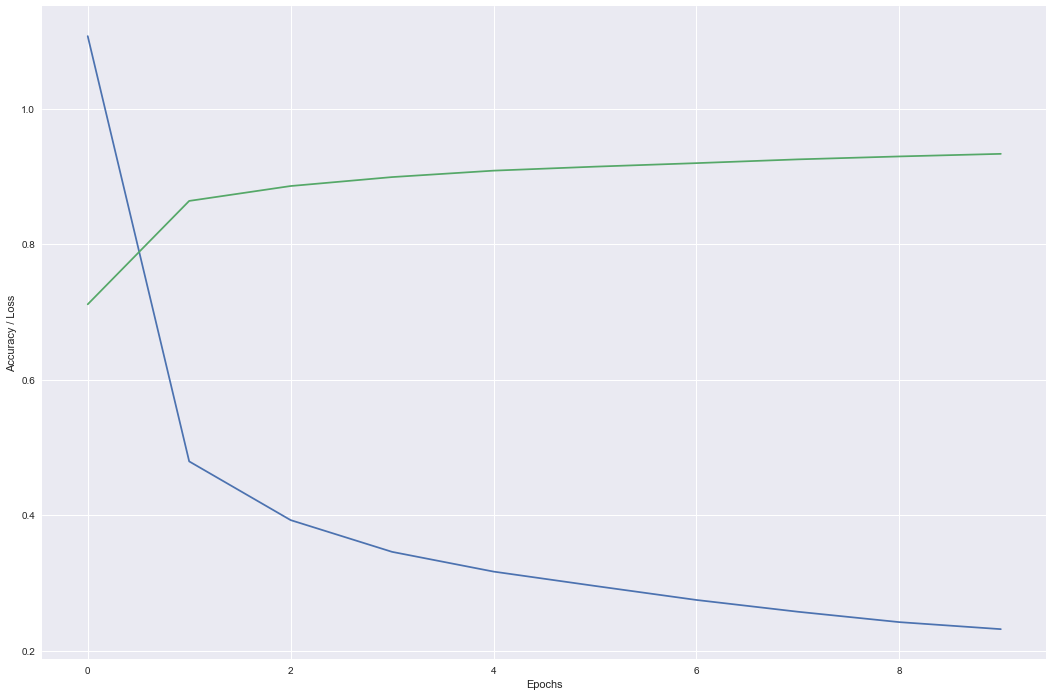

In [49]:
figure = pplt.figure(figsize = (18, 12))
axes   = figure.add_subplot(111)

axes.plot(history.history['loss'])
axes.plot(history.history['acc'])

axes.set_xlabel('Epochs')
axes.set_ylabel('Accuracy / Loss')

### `TFLearn`
##### Multi Layer Perceptron
```python
>>> import tflearn
>>> net   = tflearn.input_data(shape = (None, 784))
>>> net   = tflearn.fully_connected(net, 512, activation = 'relu')
>>> net   = tflearn.dropout(net, 0.2)
>>> net   = tflearn.fully_connected(net, 512, activation = 'relu')
>>> net   = tflearn.dropout(net, 0.2)
>>> net   = tflearn.fully_connected(net,  10, activation = 'softmax')
>>> net   = tflearn.regression(net, optimizer = 'adam', loss = 'categorical_crossentropy')

>>> model = tflearn.DNN(net)
>>> model.fit(Xtrain, ytrain)
>>> model.predict(Xtest)
```

In [50]:
import tflearn

net   = tflearn.input_data(shape = [None, len(Xtrain.columns)])
net   = tflearn.fully_connected(net, 512, activation = 'relu')
net   = tflearn.dropout(net, 0.2)
net   = tflearn.fully_connected(net, 512, activation = 'relu')
net   = tflearn.dropout(net, 0.2)
net   = tflearn.fully_connected(net, len(ytrain.columns), activation = 'softmax')
net   = tflearn.regression(net, optimizer = 'adam', loss = 'categorical_crossentropy')

model = tflearn.DNN(net)
model.fit(Xtrain.values, ytrain.values)

Training Step: 9379  | total loss: 0.39275 | time: 12.238s
| Adam | epoch: 010 | loss: 0.39275 -- iter: 59968/60000
Training Step: 9380  | total loss: 0.40947 | time: 12.250s
| Adam | epoch: 010 | loss: 0.40947 -- iter: 60000/60000
--


In [51]:
pred   = np.argmax(model.predict(Xtest.values), 1)
report = classification_report(pred, actual, target_names = list(map(str, range(0, 10))))

print(report)

             precision    recall  f1-score   support

          0       0.99      0.96      0.98      1011
          1       0.99      0.97      0.98      1158
          2       0.96      0.98      0.97      1015
          3       0.96      0.98      0.97       992
          4       0.97      0.96      0.97       989
          5       0.95      0.98      0.97       871
          6       0.96      0.98      0.97       937
          7       0.97      0.95      0.96      1057
          8       0.96      0.94      0.95       990
          9       0.94      0.97      0.95       980

avg / total       0.97      0.97      0.97     10000



#### Convolutional Neural Networks

![](http://d3kbpzbmcynnmx.cloudfront.net/wp-content/uploads/2015/11/Screen-Shot-2015-11-07-at-7.26.20-AM.png)

#### CIFAR-10 Data Set
> CIFAR - Canadian Institute for Advanced Research

In [1]:
from keras.datasets import cifar10

Using TensorFlow backend.


In [2]:
(Xtrain, ytrain), (Xtest, ytest) = cifar10.load_data()

#### VGG-Net
> VGG - Visual Geometry Group (University of Oxford)

* VGG-Net (a Convolutional Neural Network) won the 2014 ILSVLRC (ImageNet Large-Scale Visual Recognition Competition)

In [54]:
from keras.applications.vgg19 import VGG19

In [55]:
# model = VGG19()

#### Inception V3

In [56]:
from keras.applications.inception_v3 import InceptionV3

In [57]:
# model = InceptionV3()